In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [5]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [6]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([0, 0])  # each age group has asymptomatic infectives
Is0 = np.array([0, 0])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

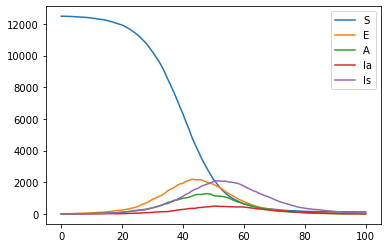

In [7]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

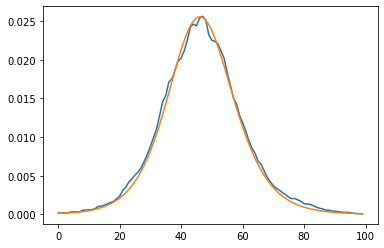

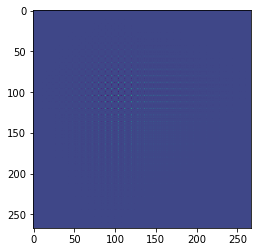

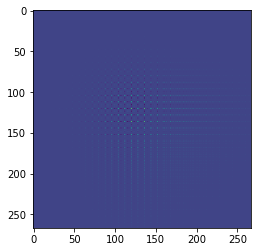

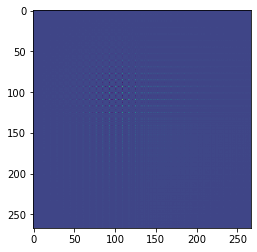

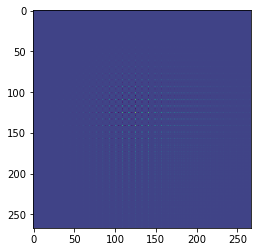

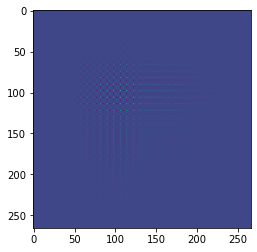

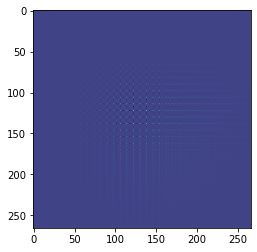

In [30]:
# load the data and rescale to intensive variables 
x = np.load('sto_traj.npy').astype('float')
x = x[:,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

# estimate mean and cov
det_model = pyross.deterministic.SEAI5R(parameters, M, fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
full_cov = full_cov#.todense()
plt.plot(x[1:,2*M])
plt.plot(xm[:,2*M])
plt.show()
for i in range(6):
    plt.imshow(full_cov[i::6,i::6])
    plt.show()

In [10]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-13452.69507849768
2.922956943511963


In [11]:
alpha_g = 0.4          ## bad initial guess
beta_g  = 0.03         ## bad initial guess
gIa_g   = 1./7            
gIs_g   = 1./7   
gE_g    = 1/5
gA_g    = 1/3
   

S0_g = S0/N
E0_g = E0/N
A0_g  = A0/N
Ia0_g = Ia0/N

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds for all the classes
bounds_for_E  = [(1/N, 14/N)]*M 
bounds_for_A  = [(1/N, 14/N)]*M 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(1/N, 14/N)]*M 
bounds_for_Ih = [(1/N, 14/N)]*M 
bounds_for_Ic = [(1/N, 14/N)]*M 
bounds_for_Im = [(1/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
alpha_b = (0.1,0.5)
beta_b  = (eps, 0.04)
gIa_b   = (eps, 0.2)
gIs_b   = (eps, 0.2)
gE_b    = (0.15, 0.25)
gA_b    = (0.3, 0.4)

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Ih, *bounds_for_Ic, *bounds_for_Im])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0, *Ih0, *Ic0, *Im0])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.30042663 0.02007585 0.1618235  0.09547444 0.18340444 0.35546075]
parameters: [0.30914768 0.02053865 0.16017374 0.09969909 0.18482508 0.35352923]
parameters: [0.33743182 0.01837161 0.15488945 0.11390144 0.18925997 0.34732796]
parameters: [0.34909405 0.02014474 0.15265285 0.11939386 0.19120218 0.344721  ]
parameters: [0.34946211 0.02039541 0.15256043 0.11962822 0.19130241 0.34462235]
parameters: [0.34793863 0.02045195 0.15282517 0.11901608 0.19108501 0.34494143]
basinhopping step 0: f -7041.31
parameters: [0.37070951 0.01685139 0.15086065 0.08026196 0.19371064 0.33617122]
parameters: [0.38281912 0.01849507 0.15539758 0.09191909 0.1898957  0.33281235]
parameters: [0.38481545 0.01832799 0.15615425 0.09378239 0.18922864 0.33225456]
parameters: [0.40290329 0.02172848 0.16294171 0.11139731 0.18330756 0.32709648]
parameters: [0.40352552 0.01988166 0.16325362 0.11182624 0.1829442  0.32691096]
parameters: [0.40154671 0.02019621 0.16250045 0.11001789 0.18362298 0.32746262]
paramete

In [12]:
# save the parameters 
np.save('param.npy', params)

In [22]:
print(params)
print(x0[5:])
bounds_for_S

[3.47938630e-01 2.04519456e-02 1.52825167e-01 1.19016076e-01
 1.91085014e-01 3.44941429e-01 2.49321594e-01 7.49320736e-01
 2.02566080e-04 8.33481520e-05 1.34571047e-04 2.74546923e-04
 3.56835647e-05 2.00000000e-06 2.00000000e-05 3.94991304e-05
 2.00000000e-05 2.00000000e-05 2.00000000e-05 2.00000000e-05
 2.00000000e-05 2.00000000e-05]
[1.34571047e-04 2.74546923e-04 3.56835647e-05 2.00000000e-06
 2.00000000e-05 3.94991304e-05 2.00000000e-05 2.00000000e-05
 2.00000000e-05 2.00000000e-05 2.00000000e-05 2.00000000e-05]


[(0.248, 0.249998), (0.748, 0.749998)]

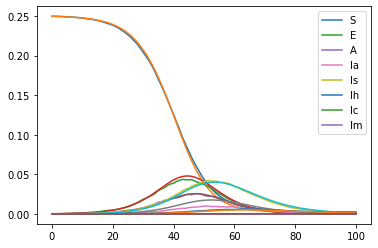

In [36]:
params = np.load('param.npy')
parameters = {'alpha':params[0],'beta':params[1], 'gIa':params[2],'gIs':params[3],
              'gIh':gIh,'gIc':gIc,  'gE':params[4], 'gA':params[5],
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
estimator.set_params(parameters)
## Compare inferred params to true_params
x0 = params[6:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)

#plt.plot(x[1:,2*M], label='A')
#plt.plot(x_det[:,2*M])
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.plot(x[:,5*M], label='Ih')
plt.plot(x_det[:, 5*M])
plt.plot(x[:,6*M], label='Ic')
plt.plot(x_det[:, 6*M])
plt.plot(x[:,7*M], label='Im')
plt.plot(x_det[:, 7*M])
plt.legend()
plt.show()